# Analisis Exploratorio de Datos

Cristobal Donoso Oliva<br>
Universidad de Concepcion, Chile<br>
cridonoso@inf.udec.cl<br>


_Viernes 16 de Octubre del 2020_

In [123]:
import pandas as pd
import numpy as np

Conjunto de datos [MRI and Alzheimers](https://www.kaggle.com/jboysen/mri-and-alzheimers) disponible en kaggle 

- `Educ`: Anos de educacion
- `SES`: Nivel Socio-Economico
- `MMSE`: Mini-mental test
- `CDR` Indice Clinico de Demencia
- `eTIV`: Volumen Intra-craneal Total estimado
- `nWBV`: Volumen Normalizado del Cerebro Completo
- `ASF`: Atlas Scaling Factor

In [127]:
long = pd.read_csv('oasis_longitudinal.csv') # Solo utilizaremos el corte longitudinal

Primero revisemos el tipo de dato de las columnas

In [23]:
long.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
dtype: object

Como podemos observar, tenemos variables numericas (`int` y `float`) y categoricas (`object`). Antes de formatear los datos debemos ver si existen **valores faltantes**

In [28]:
long.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

En este caso, `.isna()` nos retorna un frame booleano indicando si la celda es `Nan`. Luego sumamos cada una de las columnas con `.sum()`. Pandas automaticamente asociara el `True` con 1 y el `False` con 0.

Como sabemos existen distintas alternativas para lidiar con <u>datos faltantes</u> (*del ingles, Missing Values*):
- Pasiva:
    - Eliminar Filas con valores faltantes
- Activa:
    - Utilizar valores de tendencia central: Media - Mediana - Moda
    - Utilizar una constante 
    - <s>k-NN: los k vecinos mas cercanos<s>
    - <s>Modelos de regresion<s>
    - <s>Modelos generativos<s>

Las ultimas tres tecnicas son mas avanzadas, las cuales revisaremos mas adelante. De todas formas [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) hay un link hacia `KNNImputer` de la libreria `scikit-learn` por si quieres adelantar contenido!

Volviendo al ejemplo, podemos ver que tenemos dos columnas con *missing values*: el nivel socioeconomico (`SES`) y el test mini-mental (`MMSE`)

Debemos tener **cuidado** con imputar datos utilizando **indiscriminadamente** cualquier tecnica de imputacion. **Tendria sentido utilizar algun valor de tendencia central en el nivel socio economico?**
<br><br>
y en el caso del `MMSE` depende de cada paciente, sin embargo, podriamos utilizar la media acotando el grupo de edad y sexo.
<br><br>
Primero utilizaremos la tecnica **pasiva** donde descartamos las filas que tenan valores faltantes. Esto significa quitar 19 y 2 filas desde `SSE` y `MMSE` respectivamente

In [140]:
long_no_missing = long.dropna(axis=0) # 0 = filas / 1 = columnas
('antes: {} - despues: {}'.format(long.shape, long_no_missing.shape))

'antes: (373, 15) - despues: (354, 15)'

In [141]:
long_no_missing.isna().sum()

Subject ID    0
MRI ID        0
Group         0
Visit         0
MR Delay      0
M/F           0
Hand          0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

Para los metodos **activos** de imputacion, podriamos observar **correlaciones** entre variables -quizas encontramos algo interesante que nos permita imputar valores:

In [57]:
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    !conda install -y seaborn

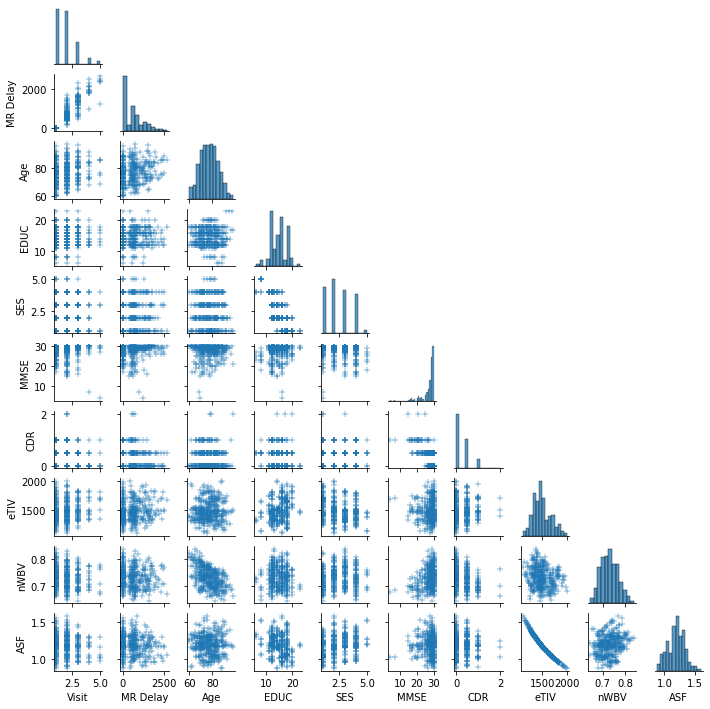

In [62]:
sns.pairplot(long_no_missing, corner=True, height=1, plot_kws=dict(marker="+"))

Es dificil ver alguna correlacion que nos permita hacer imputacion sobre el valor del MMSE basado en otros indicadores. Sin embargo, la variable categorica `Group` nos puede dar mas informacion respecto al valor estimado a imputar

In [107]:
long[long['MMSE'].isna()] # los datos faltantes corresponden a dos personas con demencia, luego

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,F,R,75,12,NaN,NaN,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,F,R,77,12,NaN,NaN,1.0,1159,0.733,1.515


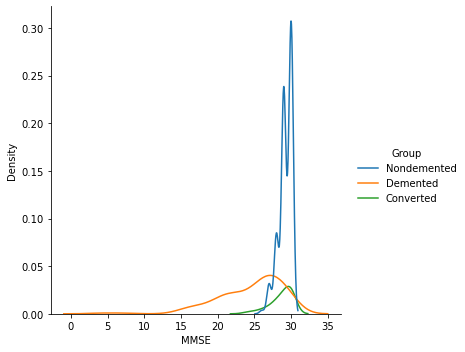

In [102]:
sns.displot(long, x='MMSE', hue='Group', kind='kde')

In [134]:
demented = long[long['Group'] == 'Demented']
long_no_nan_mean = long.fillna(demented.mean())
long_no_nan_mean[long['MMSE'].isna()]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,F,R,75,12,2.771654,24.513889,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,F,R,77,12,2.771654,24.513889,1.0,1159,0.733,1.515


Con el metodo `.fillna()` aplicaremos la funcion a cada uno de los valores faltante. En caso que solo quisieramos modificar una de las columnas (en este caso `MMSE`):

In [138]:
long_no_nan_mmse = long.replace({'MMSE': {np.nan: demented['MMSE'].mean()} })
long_no_nan_mmse[long['MMSE'].isna()]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
357,OAS2_0181,OAS2_0181_MR2,Demented,2,539,F,R,75,12,NaN,24.513889,1.0,1169,0.742,1.501
358,OAS2_0181,OAS2_0181_MR3,Demented,3,1107,F,R,77,12,NaN,24.513889,1.0,1159,0.733,1.515


## Ejemplo t-Test 

La **prueba t de Student** no permite estudiar si la diferencia observada entre las medias de dos grupos es significativa. El **puntaje t** indica la razon entre la diferencia entre dos grupos y dentro de cada grupo. 
> Mientras mas alto el puntaje t, mayor es la diferencia entre los grupos. De igual forma, un puntaje bajo indica mayor similaridad entre grupos.

Ahora estudiemos el nivel de significancia de las variables medidas anteriormente. Sin aplicar un algoritmo de clasificacion, podriamos aproximarnos a **entender que variable es mas importante con respecto a una variable objetivo**. Por ejemplo, ver si existe alguna dependencia que condicione el valor de `CDR`

#### Supuestos

- Las poblaciones deben seguir una distribucion normal
- Varianzas similares
- El mismo numero de muestras por clase (idealmente 20+)

In [224]:
grupo_h = long_no_missing[long_no_missing['M/F'] == 'M']['CDR'].sample(n=150)
grupo_m = long_no_missing[long_no_missing['M/F'] == 'F']['CDR'].sample(n=150)

In [225]:
print('std_h: {:.2f} - std_m: {:.2f}'.format(np.var(grupo_h), np.var(grupo_m)))
print('std_h: {:.2f} - std_m: {:.2f}'.format(grupo_h.size, grupo_m.size))

std_h: 0.13 - std_m: 0.13
std_h: 150.00 - std_m: 150.00


#### Hipotesis

- H0: El `CDR` medio es igual para hombres y mujeres
- H1: El `CDR` medio es distinto para hombres y mujeres

#### Intervalo de Confianza y grados de libertad
El indice de confianza $\alpha$ usualmente es 0.05. Esto quiere decir que **hay un 95% de confianza que la conclusion del test sea valida**

<img width=500, height=400 src="images/confidence_interval_95.png">

In [235]:
alpha = 0.05

Los grados de libertad se calculan como: 
<center>
    $df = n_x + n_y - 2$
</center><br>
donde $df$ son los grados de libertad y $n_x$, $n_x$ es la cantidad de muestras para el grupo $x$ e $y$ respectivamente

#### Calculo del estadistico t

<center>$
    \text{t-value} = \frac{|\hat{x_1} - \hat{x_2}|}{\text{SED}}\text{, donde SED} = \sqrt{\frac{S_1^2}{n_1} + \frac{S_2^2}{n_2}}
$</center>

In [227]:
Nh = grupo_h.size
mean_h = grupo_h.mean()
std_h = grupo_h.std()
# ================
Nm = grupo_m.size
mean_m = grupo_m.mean()
std_m = grupo_m.std()

In [228]:
SED = np.sqrt(std_h**2/Nh + std_m**2/Nm) # ERROR ENTRE DESVIACIONES 
t = (mean_h - mean_m)/SED # Puntaje t

#### Comparando con el puntaje t critico 
Para hacer esto usualmente ocupamos una tabla el cual muestra el puntaje fijo dado los grados de libertad y valores de $\alpha$. Sin embargo, podemos utilizar el paquete de python `scipy` nos permite calcular el valor rapidamente: 

In [229]:
from scipy import stats

In [230]:
df = 2*long_no_missing.size - 2
p = 1 - stats.t.cdf(t, df=df) # p-value despues de comparar con "t" calculado

In [231]:
print("t = {:.4f}".format(t))
print("p = {:.4f}".format(2*p))

t = 3.6175
p = 0.0003


Tambien podemos hacer todo el proceso anterior utilizando la funcion `ttest_ind()` de `stats`

In [232]:
t2, p2 = stats.ttest_ind(grupo_h,grupo_m)
print("t = {:.4f}".format(t2))
print("p = {:.4f}".format(p2))

t = 3.6175
p = 0.0003


Dado los resultados del test se puede concluir:
- Si el **estadistico t es mayor que el valor critico**, entonces concluimos que **hay diferencia significativa entre las dos poblaciones**. En otras palabras <u>rechazamos</u> la hipotesis nula
- Si el **estadistico t es menor que el valor critico**, entonces **no hay una diferencia significativa entre los dos grupos**. En otras palabras <u>no podemos rechazar la hipotesis nula</u> y debemos aceptar la otra hipotesis

En este caso tenemos el *p-value* que es la probabilidad de aceptacion de nuestra hipotesis nula

In [233]:
reject = p > alpha

str_1 = 'Las medias no tienen una diferencia significativa'
str_2 = 'Las medias tienen una diferencia significativa (Rechazamos hipotesis nula)'

print(str_1) if not reject else print(str_2)

Las medias no tienen una diferencia significativa
